In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import cm
from matplotlib import colors as mcolors
from scdna_replication_tools.plot_utils import get_clone_cmap, get_phase_cmap

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

In [3]:
def get_site_cmap():
    cmap = {
        'SPECTRUM-OV-081_S1_LEFT_ADNEXA': 'powderblue',
        'SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM': 'darkseagreen',
    }
    return cmap

### Load and plot data showing the distribution of scRNA cell cycle phases at the two different sites

In [4]:
scrna_df = pd.read_csv('scdna_replication_paper/data/spectrum/SPECTRUM-OV-081_cell_cycle_meta.csv')

# count the number of cells within each site & phase combination
count_df = scrna_df[['site', 'Phase']].value_counts().reset_index().rename(columns={0: 'num_cells', 'Phase': 'phase'}).sort_values(by=['site', 'phase']).reset_index(drop=True)
count_df

,site,phase,num_cells
0,INFRACOLIC_OMENTUM,G1,1885
1,INFRACOLIC_OMENTUM,G2M,472
2,INFRACOLIC_OMENTUM,S,449
3,LEFT_ADNEXA,G1,1455
4,LEFT_ADNEXA,G2M,962
5,LEFT_ADNEXA,S,691


In [5]:

def plot_scrna_phase_pie(count_df, ax0, ax1):
    # plot the distribution of cell cycle phases for each site as pie charts
    cmap = get_phase_cmap()
    ax0.pie(count_df.query('site=="LEFT_ADNEXA"')['num_cells'], labels=count_df.query('site=="LEFT_ADNEXA"')['phase'], autopct='%1.1f%%', shadow=True, startangle=90, colors=[cmap[x] for x in count_df.query('site=="LEFT_ADNEXA"')['phase']])
    ax1.pie(count_df.query('site=="INFRACOLIC_OMENTUM"')['num_cells'], labels=count_df.query('site=="INFRACOLIC_OMENTUM"')['phase'], autopct='%1.1f%%', shadow=True, startangle=90, colors=[cmap[x] for x in count_df.query('site=="INFRACOLIC_OMENTUM"')['phase']])

    ax0.set_title('Left adnexa (primary)\nNGD clones dominant')
    ax1.set_title('Infracolic omentum (met)\nWGD clone dominant')


### Load data to show S-phase enrichment plots for each clone and site combination

In [6]:
df = pd.read_csv('scdna_replication_paper/analysis/spectrum/{dataset}/cell_cycle_clone_counts.csv.gz'.format(dataset='SPECTRUM-OV-081'))
df.head()

,clone_id,num_cells_s,num_cells_g,clone_frac_s,clone_frac_g,positive_p,negative_p,library_id,positive_p_adj,negative_p_adj
0,A,4.0,0.0,0.009153,0.000000,0.000000e+00,1.000000e+00,128673A,0.000000e+00,2.800000e+01
1,B,4.0,0.0,0.009153,0.000000,0.000000e+00,1.000000e+00,128673A,0.000000e+00,2.800000e+01
2,C,248.0,74.0,0.567506,0.493333,7.376205e-11,1.000000e+00,128673A,2.065337e-09,2.800000e+01
3,D,162.0,67.0,0.370709,0.446667,1.000000e+00,2.665662e-10,128673A,2.800000e+01,7.463854e-09
4,E,5.0,0.0,0.011442,0.000000,0.000000e+00,1.000000e+00,128673A,0.000000e+00,2.800000e+01


In [7]:
# delete clone B from the S-phase population and then move all clones up one index (C->B, D->C, etc.) with the exception of clone A
df = df.loc[df['clone_id'] != 'B']
clone_remap_081 = {'C': 'B', 'D': 'C', 'E': 'D', 'F': 'E', 'G': 'F',}
df['clone_id'] = df['clone_id'].replace(clone_remap_081)

In [8]:
# add a column to df that maps library_id 128673A to LEFT_ADNEXA and 128689A to INFRACOLIC_OMENTUM
df['site'] = df['library_id'].map({'128673A': 'SPECTRUM-OV-081_S1_LEFT_ADNEXA', '128689A': 'SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM'})

# drop the 'all' library by removing NaNs
df = df.dropna(subset=['site'])

df.head()

,clone_id,num_cells_s,num_cells_g,clone_frac_s,clone_frac_g,positive_p,negative_p,library_id,positive_p_adj,negative_p_adj,site
0,A,4.0,0.0,0.009153,0.000000,0.000000e+00,1.000000e+00,128673A,0.000000e+00,2.800000e+01,SPECTRUM-OV-081_S1_LEFT_ADNEXA
2,B,248.0,74.0,0.567506,0.493333,7.376205e-11,1.000000e+00,128673A,2.065337e-09,2.800000e+01,SPECTRUM-OV-081_S1_LEFT_ADNEXA
3,C,162.0,67.0,0.370709,0.446667,1.000000e+00,2.665662e-10,128673A,2.800000e+01,7.463854e-09,SPECTRUM-OV-081_S1_LEFT_ADNEXA
4,D,5.0,0.0,0.011442,0.000000,0.000000e+00,1.000000e+00,128673A,0.000000e+00,2.800000e+01,SPECTRUM-OV-081_S1_LEFT_ADNEXA
5,E,5.0,0.0,0.011442,0.000000,0.000000e+00,1.000000e+00,128673A,0.000000e+00,2.800000e+01,SPECTRUM-OV-081_S1_LEFT_ADNEXA


In [9]:
def plot_s_phase_enrichment(df, dataset, ax0, ax1, pt_size=5):
    pthresh = 1e-2

    # create custom legend for clones & timepoints
    clone_cmap = get_clone_cmap()
    site_cmap = get_site_cmap()
    clone_legend_elements = [
        Line2D([0], [0], marker='^', color='w', label='enriched'.format(pthresh), markerfacecolor='k', markersize=pt_size),
        Line2D([0], [0], marker='v', color='w', label='depleted'.format(pthresh), markerfacecolor='k', markersize=pt_size)
    ]
    # site_legend_elements = clone_legend_elements.copy()
    for i, c in enumerate(sorted(df.clone_id.unique())):
        color = clone_cmap[c]
        clone_legend_elements.append(Patch(facecolor=color, label=c))

    site_legend_elements = []
    for i, s in enumerate(df.site.unique()):
        color = site_cmap[s]
        site_str = s.replace('SPECTRUM-OV-081_S1_', '').replace('_', ' ').lower()
        site_legend_elements.append(Patch(facecolor=color, label=site_str))

    # draw scatterplot comparing the relative fraction of each clone in S vs G1/2 phases
    for i, row in df.iterrows():
        clone_id = row['clone_id']
        site = row['site']
        if row['positive_p_adj'] < pthresh:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], marker='^', s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=site_cmap[site], marker='^', s=pt_size)
        elif row['negative_p_adj'] < pthresh:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], marker='v', s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=site_cmap[site], marker='v', s=pt_size)
        else:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=site_cmap[site], s=pt_size)

    # draw y=x line where we expect "neutral" clones to lie
    lims = [
        np.min([ax0.get_xlim(), ax0.get_ylim()]),  # min of both axes
        np.max([ax0.get_xlim(), ax0.get_ylim()]),  # max of both axes
    ]
    ax0.plot(lims, lims, 'k--', alpha=0.25, zorder=0)
    ax1.plot(lims, lims, 'k--', alpha=0.25, zorder=0)

    # ax0.legend(handles=clone_legend_elements, title='clone')
    ax0.legend(handles=clone_legend_elements, title='clone ID', frameon=False, loc='upper left')
    ax1.legend(handles=site_legend_elements, title='site', frameon=False, loc='upper left')
    ax0.set_title('{}: S-phase enrichment\ncolored by clone'.format(dataset))
    ax1.set_title('{}: S-phase enrichment\ncolored by site'.format(dataset))
    ax0.set_ylabel('S-phase clone fraction')
    for ax in [ax0, ax1]:
        ax.set_xlabel('G1/2-phase clone fraction')
        sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

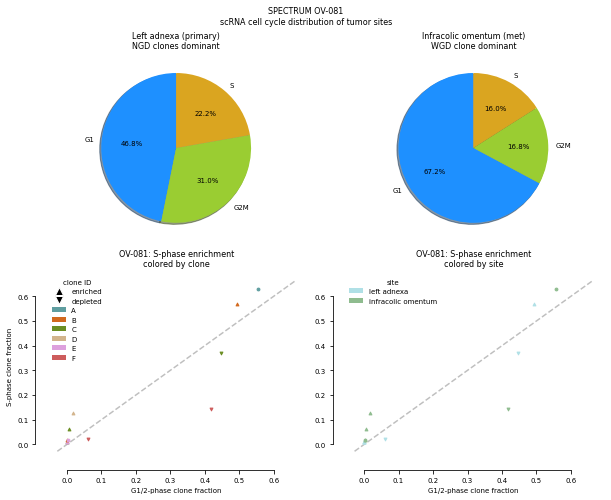

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8.5, 7), tight_layout=True)

fig.suptitle('SPECTRUM OV-081\nscRNA cell cycle distribution of tumor sites')

plot_scrna_phase_pie(count_df, ax[0, 0], ax[0, 1])

plot_s_phase_enrichment(df, 'OV-081', ax[1, 0], ax[1, 1], pt_size=8)

fig.savefig('scdna_replication_paper/manuscript/extended_data_figs/figED9.pdf', dpi=300, bbox_inches='tight')

plt.show()